In [27]:
# Load Depedencies

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.models as models
import torch.optim as optim
import os
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchattacks
import matplotlib.pyplot as plt
from trades import new_trade_loss
from torchmetrics.functional.image import peak_signal_noise_ratio, structural_similarity_index_measure

### Hyperparameters

In [28]:
model_name = "Googlenet"
version = "v1"
training_name = "TRADES"
num_classes = 7
batch_size = 32
learning_rate = 0.0001
lr_factor = 0.1
lr_threshold = 5
epochs = 50
height = 224
lambda_tradeoff = 0.7

epsilon = 8.0/255
alpha = 2.0/255
steps = 4

In [29]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Graph writer initialize
writer = SummaryWriter("runs/trashbox/" + f'{training_name}--{model_name}.{version}')

### Preprocessing

In [30]:
preprocessing = transforms.Compose([
    transforms.RandomResizedCrop((height, height)),
    transforms.ToTensor()
])

### Dataset

In [31]:
trash_train_dataset = torchvision.datasets.ImageFolder('dataset/trashbox/train', transform=preprocessing)
trash_train_loader = torch.utils.data.DataLoader(dataset=trash_train_dataset, shuffle=True, batch_size=batch_size)
trash_val_dataset = torchvision.datasets.ImageFolder('dataset/trashbox/val', transform=preprocessing)
trash_val_loader = torch.utils.data.DataLoader(dataset=trash_val_dataset, shuffle=True, batch_size=batch_size)

### Model

In [32]:
# Setup model
model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
infeatures = model.fc.in_features
model.fc = nn.Linear(infeatures, 7, True)

# # Enable if will be using pre-trained model
# checkpoint = torch.load('./best_trained_models/best_NORMAL--VGG16.v1_epoch49.pth')

# if 'module' in list(checkpoint['net'].keys())[0]:
#     new_state_dict = {k.replace("module.", ""): v for k, v in checkpoint['net'].items()}
#     model.load_state_dict(new_state_dict)
# else:
#     model.load_state_dict(checkpoint['net'])

model = model.to(device)

### Attack; Criterion

In [33]:
atk = torchattacks.PGDL2(model, epsilon, alpha, steps)

### Preview of image

tensor(1.)
tensor(0.)


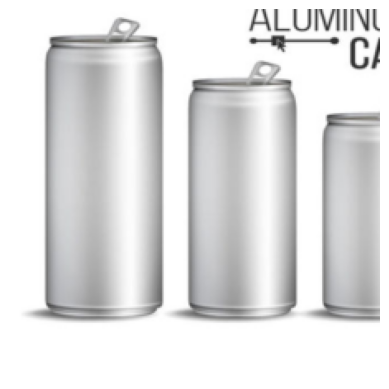

In [34]:
examples = iter(trash_val_loader)
samples, labels = next(examples)

if samples.ndim > 3:
    new_samples = samples.squeeze()

    # If the tensor has 4 dimensions (batch dimension), select the first image in the batch
if samples.ndim == 4:
    new_samples = samples[0]
image_array = new_samples.permute(1, 2, 0).numpy()

# Show min and max values for normalization
print(torch.max(samples))
print(torch.min(samples))

plt.imshow(image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

### Preview of Adversarial sample

c:\Users\Acer\.conda\envs\thesisaimodel\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


tensor(1.)
tensor(0.)


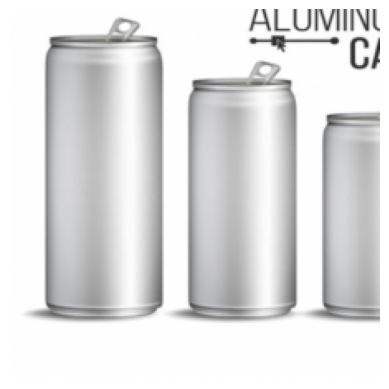

In [35]:
adv_image = atk(samples, labels)
adv_image = adv_image.cpu().detach()

print(torch.max(adv_image))
print(torch.min(adv_image))

if adv_image.ndim > 3:
    new_adv_samples = adv_image.squeeze()

    # If the tensor has 4 dimensions (batch dimension), select the first image in the batch
if adv_image.ndim == 4:
    new_adv_samples = adv_image[0]
image_array = new_adv_samples.permute(1, 2, 0).numpy()
plt.imshow(image_array)
plt.axis('off')  # Turn off axis labels
plt.show()

In [36]:
def train(epoch, optimizer): 
    print(f'Train epoch no. [{epoch}]')
    train_loss = 0
    nat_correct = 0
    adv_correct = 0
    total = 0
    total_ssim = 0
    total_psnr = 0
    model.train()
    iterator = tqdm(trash_train_loader, ncols=0, leave=False)
    for i, (inputs, targets)in enumerate(iterator):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        adv_sample = atk(inputs, targets)

        output = model(inputs)
        adv_output = model(adv_sample)
        loss = new_trade_loss(model, inputs, adv_sample, targets, lambda_tradeoff)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, nat_predicted = output.max(1)
        _, adv_predicted = adv_output.max(1)
        
        total += targets.size(0)
        adv_correct += adv_predicted.eq(targets).sum().item()
        nat_correct += nat_predicted.eq(targets).sum().item()

        # SSIM and PSNR 
        total_psnr += peak_signal_noise_ratio(adv_sample, inputs, reduction='sum')
        total_ssim += structural_similarity_index_measure(adv_sample, inputs, reduction='sum')
    
    # SSIM and PSNR Average
    avg_ssim = total_ssim / total
    avg_psnr = total_psnr / total

    writer.add_scalar("Average SSIM: " + model_name, avg_ssim, epoch)
    writer.add_scalar("Average PSNR: " + model_name, avg_psnr, epoch)

    training_loss = train_loss / len(trash_train_loader)
    nat_acc = 100. * nat_correct / total
    adv_acc = 100. * adv_correct / total

    print('Nat train accuarcy:', nat_acc)
    print('Adv train accuarcy:', adv_acc)
    print('Validation loss:', training_loss)
    
    writer.add_scalar('Adversarial Train loss: ' + model_name, training_loss, epoch)
    writer.add_scalar('Natural Train accuracy: ' + model_name, nat_acc, epoch)
    writer.add_scalar('Adversarial Train accuracy: ' + model_name, adv_acc, epoch)
    return train_loss

In [37]:
# Test function
best_nat_acc = float(0)

def test(epoch, optimizer):
    global best_nat_acc
    print('\n[ Test epoch: %d ]' % epoch)
    model.eval()
    benign_loss = 0
    adv_loss = 0
    benign_correct = 0
    adv_correct = 0
    total = 0
    with torch.no_grad():
        iterator = tqdm(trash_val_loader, ncols=0, leave=False)
        for i, (inputs, targets) in enumerate(iterator):
            inputs, targets = inputs.to(device), targets.to(device)
            total += targets.size(0)

            with torch.enable_grad():
                adv_image = atk(inputs, targets) 

            adv_outputs = model(adv_image)
            natural_outputs = model(inputs)
            _, adv_predicted = adv_outputs.max(1)
            _, natural_predicted = natural_outputs.max(1)
            
            benign_correct += natural_predicted.eq(targets).sum().item()
            adv_correct += adv_predicted.eq(targets).sum().item()
    
    benign_val_accuracy = 100.0 * benign_correct / total
    adv_val_accuracy = 100.0 * adv_correct / total 
    
    print('\nTotal benign test accuarcy:', benign_val_accuracy)
    print('Total adversarial test Accuarcy:', adv_val_accuracy)
    
    # Graph
    writer.add_scalar("Natural test accuracy: " + model_name, benign_val_accuracy, epoch)
    writer.add_scalar("Adversarial test accuracy: " + model_name, adv_val_accuracy, epoch)
    
    # Save checkpoint
    state = {
        'epoch' : epoch,
        'net': model.state_dict(),
        'optim' : optimizer.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + f'{training_name}--{model_name}.{version}.pth')
    if benign_val_accuracy > best_nat_acc:
        print(f'Model saved: f{benign_val_accuracy}')
        best_nat_acc = benign_val_accuracy
        torch.save(state, './trained_model/' + f'best_{training_name}_{model_name}_{version}_epoch{epoch}.pth')
    print('Model Saved!')
    return benign_val_accuracy, adv_val_accuracy

In [38]:
def main():
    global learning_rate
    learning_rate = learning_rate
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0002)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=lr_threshold, factor=0.1)

    model_path = f'./checkpoint/{training_name}--{model_name}.{version}.pth'
    if os.path.exists(model_path):
        # Load the saved model and optimizer state
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['net'])
        optimizer.load_state_dict(checkpoint['optim'])
        start_epoch = checkpoint['epoch']
        print(f"=> Loaded checkpoint '{model_path}' (epoch {start_epoch})")
    else:
        start_epoch = 0
        print(f"=> No checkpoint found at '{model_path}'. Starting training from scratch.")

    for epoch in range(start_epoch, epochs):
        train_loss = train(epoch, optimizer)
        test(epoch, optimizer)
        scheduler.step(metrics=train_loss, epoch=epoch)
        scheduler.print_lr(True, model.parameters(), learning_rate, epoch)


In [39]:
if __name__ == '__main__':
    main()

=> Loaded checkpoint './checkpoint/TRADES--Googlenet.v1.pth' (epoch 0)
Train epoch no. [0]


  0% 0/447 [00:00<?, ?it/s]c:\Users\Acer\.conda\envs\thesisaimodel\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU  (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 